# ML: Como utilizar o otimizador Optuna e a métrica log_loss

## Problema de negócio:

No ano fiscal de 2016, o OFLC processou 775.979 pedidos de empregadores para 1.699.957 posições de certificações de trabalho temporárias e permanentes. Isso representou um aumento de nove por cento no número total de pedidos processados em relação ao ano anterior. O processo de revisar cada caso está se tornando uma tarefa tediosa à medida que o número de candidatos aumenta a cada ano.

O aumento do número de candidatos a cada ano demanda uma solução baseada em Aprendizado de Máquina que possa ajudar na pré-seleção dos candidatos com maiores chances de aprovação de VISTO. O OFLC contratou sua empresa, TopVistos, para soluções baseadas em dados. Como Cientista de Dados, você deve analisar os dados fornecidos e, com a ajuda de um modelo de classificação:

Facilitar o processo de aprovação de vistos.

Recomendar um perfil adequado para os candidatos para os quais o visto deve ser certificado ou negado, com base nos fatores que influenciam significativamente o status do caso.

Link com os dados: https://www.kaggle.com/competitions/ml-olympiad-for-students-topvistos-eua/overview

### Etapa 1 - Carga dos dados

In [1]:
# Carregando os pacotes necessários
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import optuna as opt

# Desabilitando a notação científica, para ficar mais fácil a análise dos dados
pd.set_option('display.float_format', '{:,.2f}'.format)

# Desabilitando os avisos
import warnings
warnings.filterwarnings('ignore')


Bad key text.latex.preview in file C:\Users\camil\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file C:\Users\camil\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file C:\Users\camil\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 418 ('savefig.jpeg_quality: 95       # when a jpeg is saved, the default quality parameter.')
You proba

In [2]:
# Carregando os dados de treino e teste
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [3]:
# Visualizando os dados de treino
df_train.head()

,id_do_caso,continente,educacao_do_empregado,tem_experiencia_de_trabalho,requer_treinamento_de_trabalho,num_de_empregados,ano_de_estabelecimento,regiao_de_emprego,salario_prevalecente,unidade_de_salario,posicao_em_tempo_integral,status_do_caso
0,EZYV10567,Europa,Ensino Médio,N,S,2087,1855,Sul,"69,711.24",Ano,S,Negado
1,EZYV5505,Ásia,Mestrado,S,N,5991,2003,Meio-Oeste,"52,931.38",Ano,S,Aprovado
2,EZYV5207,Ásia,Ensino Médio,N,N,1426,2000,Ilha,"110,830.21",Ano,S,Negado
3,EZYV7545,Ásia,Ensino Médio,N,N,3846,1992,Meio-Oeste,"91,884.68",Semana,S,Negado
4,EZYV16071,Ásia,Ensino Superior,S,N,3957,1949,Nordeste,"138,155.24",Ano,S,Aprovado


In [4]:
# Visualizando os dados de teste
df_test.head()

,id_do_caso,continente,educacao_do_empregado,tem_experiencia_de_trabalho,requer_treinamento_de_trabalho,num_de_empregados,ano_de_estabelecimento,regiao_de_emprego,salario_prevalecente,unidade_de_salario,posicao_em_tempo_integral
0,EZYV22339,Ásia,Ensino Superior,S,N,2414,1973,Nordeste,"103,320.80",Ano,N
1,EZYV9333,Ásia,Mestrado,N,S,2928,1937,Oeste,"49,786.35",Ano,S
2,EZYV9740,Ásia,Ensino Superior,S,N,1836,1999,Oeste,"60,855.83",Ano,S
3,EZYV3328,Ásia,Ensino Superior,S,N,122,2004,Sul,"82,379.06",Semana,S
4,EZYV12321,América do Sul,Ensino Superior,S,S,1720,2003,Nordeste,"6,719.81",Ano,S


In [5]:
# Codificando a variável target nos dados de treino
df_train['status_do_caso'] = df_train['status_do_caso'].map({'Negado': 0, 'Aprovado': 1})

### Etapa 2 - Análise Exploratória dos dados

In [6]:
# Verificando o tipo dos dados e quantidade de observações por coluna
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17836 entries, 0 to 17835
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id_do_caso                      17836 non-null  object 
 1   continente                      17836 non-null  object 
 2   educacao_do_empregado           17836 non-null  object 
 3   tem_experiencia_de_trabalho     17836 non-null  object 
 4   requer_treinamento_de_trabalho  17836 non-null  object 
 5   num_de_empregados               17836 non-null  int64  
 6   ano_de_estabelecimento          17836 non-null  int64  
 7   regiao_de_emprego               17836 non-null  object 
 8   salario_prevalecente            17836 non-null  float64
 9   unidade_de_salario              17836 non-null  object 
 10  posicao_em_tempo_integral       17836 non-null  object 
 11  status_do_caso                  17836 non-null  int64  
dtypes: float64(1), int64(3), object(

In [7]:
# Criando uma função para verificar os valores únicos para cada coluna do dataset
def valor_unico (df):
    valor_unico = {}
    
    for c in df.columns:
        valor_unico[c] = df[c].unique()
    
    return valor_unico 

In [8]:
# Verificando os valores únicos somente para as variáveis do tipo objeto
valor_unico(df_train.select_dtypes(include='object'))

{'id_do_caso': array(['EZYV10567', 'EZYV5505', 'EZYV5207', ..., 'EZYV8903', 'EZYV6163',
        'EZYV4219'], dtype=object),
 'continente': array(['Europa', 'Ásia', 'América do Sul', 'América do Norte', 'África',
        'Oceania'], dtype=object),
 'educacao_do_empregado': array(['Ensino Médio', 'Mestrado', 'Ensino Superior', 'Doutorado'],
       dtype=object),
 'tem_experiencia_de_trabalho': array(['N', 'S'], dtype=object),
 'requer_treinamento_de_trabalho': array(['S', 'N'], dtype=object),
 'regiao_de_emprego': array(['Sul', 'Meio-Oeste', 'Ilha', 'Nordeste', 'Oeste'], dtype=object),
 'unidade_de_salario': array(['Ano', 'Semana', 'Hora', 'Mês'], dtype=object),
 'posicao_em_tempo_integral': array(['S', 'N'], dtype=object)}

In [9]:
# Verificando a estatística das variáveis numéricas
df_train.describe()

,num_de_empregados,ano_de_estabelecimento,salario_prevalecente,status_do_caso
count,"17,836.00","17,836.00","17,836.00","17,836.00"
mean,"5,726.50","1,979.49","74,327.43",0.67
std,"23,321.38",42.10,"52,795.86",0.47
min,-26.00,"1,800.00",2.14,0.00
25%,"1,023.00","1,976.00","33,892.91",0.00
50%,"2,117.00","1,997.00","70,106.92",1.00
75%,"3,504.25","2,005.00","107,564.71",1.00
max,"602,069.00","2,016.00","319,210.27",1.00


Pelos dados estatísticos é possível observar 3 possíveis problemas nos dados:
- Na coluna número de empregados existem valores negativos e valores muito altos, que podem ser outliers;
- No ano de estabelecimento o valor mínimo é 1800, o que pode estar errado;
- O salário possui unidades de medidas diferentes, então, vale padronizar.

In [10]:
# Verificando quantas observações possuem empregados com números negativos ou zerados
df_train[df_train["num_de_empregados"] <= 0].shape

(29, 12)

Como são apenas 29 registros, vale remover estes casos, pois, provavelmente são outliers. Porém, antes da remoção, será verificado se esta variável é importante para o modelo. Caso não seja, o tratamento não será necessário.

In [11]:
# Verificando as observações com maiores valores
df_train.sort_values("num_de_empregados").tail(10)

,id_do_caso,continente,educacao_do_empregado,tem_experiencia_de_trabalho,requer_treinamento_de_trabalho,num_de_empregados,ano_de_estabelecimento,regiao_de_emprego,salario_prevalecente,unidade_de_salario,posicao_em_tempo_integral,status_do_caso
11006,EZYV3865,Europa,Doutorado,N,N,412207,1984,Sul,"9,789.32",Ano,S,1
15122,EZYV3732,América do Norte,Mestrado,S,N,428773,2004,Nordeste,"39,191.89",Ano,S,1
14594,EZYV24072,América do Norte,Doutorado,N,N,459450,2001,Nordeste,"115,296.62",Ano,S,1
6866,EZYV8627,Europa,Ensino Superior,S,N,461527,2005,Sul,"27,597.39",Ano,S,0
257,EZYV15269,Ásia,Ensino Superior,S,S,499720,1948,Oeste,"47,992.00",Ano,S,1
12496,EZYV2784,Ásia,Ensino Médio,S,N,517884,1979,Sul,"108,936.22",Ano,S,0
13920,EZYV11318,Ásia,Mestrado,N,N,579004,1969,Sul,"103,507.01",Ano,N,1
6484,EZYV20346,Ásia,Mestrado,N,N,581468,1984,Nordeste,"41,397.52",Ano,N,1
12673,EZYV1346,Ásia,Ensino Superior,N,N,594472,1887,Oeste,"87,144.20",Ano,S,0
2735,EZYV21340,América do Norte,Doutorado,S,N,602069,2011,Nordeste,"25,181.63",Ano,S,1


Existem muitas empresas com alto nº de funcionários, o que dá entender que não são outliers. Além disso, ao fazer uma pesquisa no Google, foi verificado que existem empresas com quase 3MM de funcionários, conforme site: https://trendings.com.br/negocios/conheca-os-maiores-empregadores-do-brasil-e-do-mundo/.
Dessa forma, essas empresas serão mantidas na base, por entender que os números não são exorbitantes.

In [12]:
# Verificando registros com anos anteriores a 1900
df_train[df_train["ano_de_estabelecimento"] < 1900].shape

(1457, 12)

Como existem muitos registros nessa situação, podem não ser erros. Portanto, os dados serão mantidos.

### Etapa 3 - Pré-processamento dos dados

In [13]:
# Como visto anteriormente, o salário está apresentado em várias unidades de medidas diferentes, necessitando de padronização.
# Para padronizar este dado, primeiramente será verificado a frequência para cada opção da coluna de unidade de medida
df_train.groupby("unidade_de_salario")["id_do_caso"].count()

unidade_de_salario
Ano       16089
Hora       1493
Mês          58
Semana      196
Name: id_do_caso, dtype: int64

In [14]:
# Como a unidade de medida com maior valor é a de ano, a coluna salário será padronizada para salário anual
# Como nos Estados unidos o normal é trabalhar 40h por semana, esse valor será considerado como referência
condicoes = [
    (df_train["unidade_de_salario"] == 'Hora') & (df_train["posicao_em_tempo_integral"] == 'S'),
    (df_train["unidade_de_salario"] == 'Hora') & (df_train["posicao_em_tempo_integral"] == 'N'),
    df_train["unidade_de_salario"] == 'Semana',
    df_train["unidade_de_salario"] == 'Mês',
    df_train["unidade_de_salario"] == 'Ano'
]

calculos = [
    df_train["salario_prevalecente"] * 2080,
    df_train["salario_prevalecente"] * 1040,
    df_train["salario_prevalecente"] * 52,
    df_train["salario_prevalecente"] * 12,
    df_train["salario_prevalecente"] * 1
]

df_train = df_train.assign(salario_ajustado=np.select(condicoes, calculos))

In [15]:
# Verificando como ficou a nova coluna
df_train.head()

,id_do_caso,continente,educacao_do_empregado,tem_experiencia_de_trabalho,requer_treinamento_de_trabalho,num_de_empregados,ano_de_estabelecimento,regiao_de_emprego,salario_prevalecente,unidade_de_salario,posicao_em_tempo_integral,status_do_caso,salario_ajustado
0,EZYV10567,Europa,Ensino Médio,N,S,2087,1855,Sul,"69,711.24",Ano,S,0,"69,711.24"
1,EZYV5505,Ásia,Mestrado,S,N,5991,2003,Meio-Oeste,"52,931.38",Ano,S,1,"52,931.38"
2,EZYV5207,Ásia,Ensino Médio,N,N,1426,2000,Ilha,"110,830.21",Ano,S,0,"110,830.21"
3,EZYV7545,Ásia,Ensino Médio,N,N,3846,1992,Meio-Oeste,"91,884.68",Semana,S,0,"4,778,003.36"
4,EZYV16071,Ásia,Ensino Superior,S,N,3957,1949,Nordeste,"138,155.24",Ano,S,1,"138,155.24"


In [16]:
# Verificando as estatísticas da nova coluna criada
df_train["salario_ajustado"].describe()

count       17,836.00
mean       196,145.42
std        566,910.92
min            115.81
25%         46,681.85
50%         82,462.45
75%        124,635.89
max     12,189,130.72
Name: salario_ajustado, dtype: float64

In [17]:
# Pode-se observar que existem valores muito pequenos e muito elevados nesta nova coluna
# Verificando os registros com valores menores que US$15 mil, que refere-se ao salário mínimo nos EUA, conforme site:
# https://www.remessaonline.com.br/blog/salario-minimo-estados-unidos/#:~:text=Quem%20ganha%20o%20sal%C3%A1rio%20m%C3%ADnimo,um%20ganho%20de%20US%24%2015.312.
df_train[df_train["salario_ajustado"] < 15000].sort_values("salario_ajustado")

,id_do_caso,continente,educacao_do_empregado,tem_experiencia_de_trabalho,requer_treinamento_de_trabalho,num_de_empregados,ano_de_estabelecimento,regiao_de_emprego,salario_prevalecente,unidade_de_salario,posicao_em_tempo_integral,status_do_caso,salario_ajustado
9461,EZYV9779,Ásia,Mestrado,S,N,1503,2001,Nordeste,115.81,Ano,S,1,115.81
7455,EZYV12722,Europa,Ensino Superior,S,N,4310,2010,Meio-Oeste,121.65,Ano,S,1,121.65
6486,EZYV11428,Europa,Mestrado,N,N,4106,1902,Sul,126.28,Ano,S,1,126.28
6830,EZYV18353,Europa,Mestrado,N,N,1702,1953,Oeste,127.89,Ano,S,1,127.89
15033,EZYV4685,Europa,Doutorado,S,N,4315,1868,Sul,135.17,Ano,S,1,135.17
...,...,...,...,...,...,...,...,...,...,...,...,...,...
46,EZYV16245,Europa,Doutorado,S,N,2053,1994,Sul,"14,905.39",Ano,S,1,"14,905.39"
14864,EZYV5698,América do Norte,Ensino Médio,S,N,147,1981,Nordeste,"14,916.55",Ano,S,1,"14,916.55"
5276,EZYV21745,Europa,Mestrado,N,N,1872,2005,Sul,"14,943.16",Ano,S,1,"14,943.16"
16606,EZYV22363,Europa,Mestrado,N,S,58,1946,Oeste,"14,978.83",Ano,S,1,"14,978.83"


In [18]:
# Há 1126 registros com salário menor que 15 mil dólares
# Vale verificar a unidade de medida destes casos, a fim de verificar se a unidade de medida pode estar errada
df_train[df_train["salario_ajustado"] < 15000].groupby("unidade_de_salario")["id_do_caso"].count()

unidade_de_salario
Ano     1118
Hora       8
Name: id_do_caso, dtype: int64

In [19]:
# Pelo que pode ser visto a maioria dos casos são de salário anual
# Verificando se os casos são referente a tempo semi integral, para fazer sentido
df_sal_baixo = df_train[df_train["salario_ajustado"] < 15000]
pd.crosstab(df_sal_baixo["unidade_de_salario"], df_sal_baixo["posicao_em_tempo_integral"])

posicao_em_tempo_integral,N,S
unidade_de_salario,,
Ano,49,1069
Hora,0,8


Pelo que pode ser visto, a maioria dos casos são anuais, com posição integral. Então, pode ser que a unidade de medida de alguns valores estejam erradas. Cabe verificar o histograma para cada unidade de medida.

<AxesSubplot:>

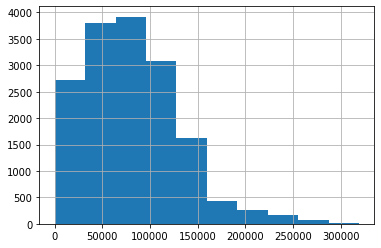

In [20]:
# Analisando o histograma para cada unidade de medida
df_train[df_train["unidade_de_salario"] == "Ano"]["salario_prevalecente"].hist()

<AxesSubplot:>

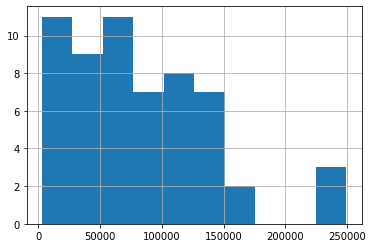

In [21]:
df_train[df_train["unidade_de_salario"] == "Mês"]["salario_prevalecente"].hist()

<AxesSubplot:>

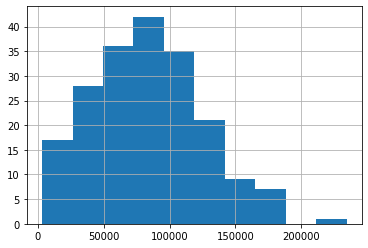

In [22]:
df_train[df_train["unidade_de_salario"] == "Semana"]["salario_prevalecente"].hist()

<AxesSubplot:>

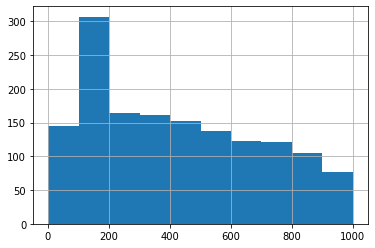

In [23]:
df_train[df_train["unidade_de_salario"] == "Hora"]["salario_prevalecente"].hist()

Pelos histogramas, parece que os dados dessa coluna estão muito errados. Portanto, antes de seguir com alguma outra transformação, serão realizadas outras análises estatísticas.

### Etapa 4 - Análises estatísticas

In [24]:
# Definindo a variável target dos dados de treino para prosseguir com as análises de correlação
y = df_train["status_do_caso"]

In [25]:
# Como a maioria das variáveis são categóricas, a correlação será feita com o teste qui-quadrado

# Definindo as variáveis que serão analisadas através do qui-quadrado
var = ["continente", "educacao_do_empregado", "tem_experiencia_de_trabalho", "requer_treinamento_de_trabalho", "regiao_de_emprego", "posicao_em_tempo_integral"]

In [26]:
# Verificando a correlação das variáveis categóricas com a variável target
for v in var:
    dados = pd.crosstab(df_train[v], y)
    stat, p_valor, _, _ = chi2_contingency(dados)
    print("Variável independente:", v)
    print("Valor do teste estatístico (χ²):", stat)
    print("Valor p:", p_valor)

Variável independente: continente
Valor do teste estatístico (χ²): 249.92453265747093
Valor p: 5.7057406064682334e-52
Variável independente: educacao_do_empregado
Valor do teste estatístico (χ²): 1954.8165625203997
Valor p: 0.0
Variável independente: tem_experiencia_de_trabalho
Valor do teste estatístico (χ²): 649.0210751607558
Valor p: 3.6476089793213424e-143
Variável independente: requer_treinamento_de_trabalho
Valor do teste estatístico (χ²): 5.373924042768497
Valor p: 0.020439944407078907
Variável independente: regiao_de_emprego
Valor do teste estatístico (χ²): 216.94467575688853
Valor p: 8.518568365546605e-46
Variável independente: posicao_em_tempo_integral
Valor do teste estatístico (χ²): 1.736898279083508
Valor p: 0.18753231564739908


In [27]:
# Verificando a correlação com as variáveis numéricas
df_train.corr()

,num_de_empregados,ano_de_estabelecimento,salario_prevalecente,status_do_caso,salario_ajustado
num_de_empregados,1.00,-0.02,-0.01,0.00,-0.00
ano_de_estabelecimento,-0.02,1.00,0.01,0.01,-0.03
salario_prevalecente,-0.01,0.01,1.00,0.07,-0.03
status_do_caso,0.00,0.01,0.07,1.00,-0.09
salario_ajustado,-0.00,-0.03,-0.03,-0.09,1.00


Pela análise de correlação, as variáveis mais importantes para o modelo são: continente, educacao_do_empregado, tem_experiencia_de_trabalho, requer_treinamento_de_trabalho e regiao_de_emprego. Portanto, o modelo será treinado com estas variáveis.

In [28]:
# Criando uma função para avaliar o percentual de aprovados e recusados em cada variável
def percent_var (var):
    df1 = df_train.groupby(var)["id_do_caso"].count().reset_index()
    df2 = df_train.groupby([var, "status_do_caso"])["id_do_caso"].count().reset_index()
    df2["sum_cont"] = pd.merge(df2, df1, on=var, how = "left", suffixes=('_A', '_B'))["id_do_caso_B"]
    df2["percent"] = round(df2["id_do_caso"] / df2["sum_cont"] * 100, 1)
    return df2

In [29]:
# Verificando o percentual da variável continente
percent_var ("continente")

,continente,status_do_caso,id_do_caso,sum_cont,percent
0,América do Norte,0,868,2295,37.80
1,América do Norte,1,1427,2295,62.20
2,América do Sul,0,250,590,42.40
3,América do Sul,1,340,590,57.60
4,Europa,0,547,2654,20.60
5,Europa,1,2107,2654,79.40
6,Oceania,0,48,139,34.50
7,Oceania,1,91,139,65.50
8,África,0,111,393,28.20
9,África,1,282,393,71.80


Todos os países possuem maior taxa de aprovação do que de recusa, porém, na Europa e África a probabilidade de aprovação é maior.

In [30]:
# Verificando o percentual da variável educacao_do_empregado
percent_var ("educacao_do_empregado")

,educacao_do_empregado,status_do_caso,id_do_caso,sum_cont,percent
0,Doutorado,0,196,1532,12.80
1,Doutorado,1,1336,1532,87.20
2,Ensino Médio,0,1583,2398,66.00
3,Ensino Médio,1,815,2398,34.00
4,Ensino Superior,0,2687,7151,37.60
5,Ensino Superior,1,4464,7151,62.40
6,Mestrado,0,1433,6755,21.20
7,Mestrado,1,5322,6755,78.80


É possível observar que quanto maior o nível de edcuação, maior a chance de ter o visto aprovado.

In [31]:
# Verificando o percentual da variável tem_experiencia_de_trabalho
percent_var ("tem_experiencia_de_trabalho")

,tem_experiencia_de_trabalho,status_do_caso,id_do_caso,sum_cont,percent
0,N,0,3256,7456,43.70
1,N,1,4200,7456,56.30
2,S,0,2643,10380,25.50
3,S,1,7737,10380,74.50


Se o candidato possuir experiência de trabalho, as chances de aprovação são maiores.

In [32]:
# Verificando o percentual da variável requer_treinamento_de_trabalho
percent_var ("requer_treinamento_de_trabalho")

,requer_treinamento_de_trabalho,status_do_caso,id_do_caso,sum_cont,percent
0,N,0,5258,15755,33.40
1,N,1,10497,15755,66.60
2,S,0,641,2081,30.80
3,S,1,1440,2081,69.20


As chances de aprovação para ambas as opções são as mesmas, portanto, pode ser que essa variável não seja tão relevante.

In [33]:
# Verificando o percentual da variável regiao_de_emprego
percent_var ("regiao_de_emprego")

,regiao_de_emprego,status_do_caso,id_do_caso,sum_cont,percent
0,Ilha,0,103,260,39.60
1,Ilha,1,157,260,60.40
2,Meio-Oeste,0,723,3011,24.00
3,Meio-Oeste,1,2288,3011,76.00
4,Nordeste,0,1883,5064,37.20
5,Nordeste,1,3181,5064,62.80
6,Oeste,0,1719,4589,37.50
7,Oeste,1,2870,4589,62.50
8,Sul,0,1471,4912,29.90
9,Sul,1,3441,4912,70.10


As regiões de emprego Meio_Oeste e Sul são as com maior chance de aprovação.

In [34]:
# Verificando o percentual da variável unidade_de_salario
percent_var ("unidade_de_salario")

,unidade_de_salario,status_do_caso,id_do_caso,sum_cont,percent
0,Ano,0,4824,16089,30.00
1,Ano,1,11265,16089,70.00
2,Hora,0,976,1493,65.40
3,Hora,1,517,1493,34.60
4,Mês,0,25,58,43.10
5,Mês,1,33,58,56.90
6,Semana,0,74,196,37.80
7,Semana,1,122,196,62.20


Trabalhos que possuem unidade de salário anual, possuem maior probabilidade de aprovação.

In [35]:
# Verificando o percentual da variável posicao_em_tempo_integral
percent_var ("posicao_em_tempo_integral")

,posicao_em_tempo_integral,status_do_caso,id_do_caso,sum_cont,percent
0,N,0,603,1902,31.70
1,N,1,1299,1902,68.30
2,S,0,5296,15934,33.20
3,S,1,10638,15934,66.80


As chances de aprovação em ambas as posições são as mesmas.

In [36]:
# Criando função para criar classe de número de empregados
def class_empregado (x):
    if x <= 500:
        return "A) 500"
    elif x <= 1000:
        return "B) 1000"
    elif x <= 5000:
        return "C) 5000"
    elif x <= 10000:
        return "D) 10000"
    else:
        return "E) >10000"    

In [37]:
# Criando a variável class_empreg
df_train["class_empreg"] = df_train["num_de_empregados"].apply(class_empregado)

# Verificando o percentual da variável class_empreg
percent_var ("class_empreg")

,class_empreg,status_do_caso,id_do_caso,sum_cont,percent
0,A) 500,0,754,2157,35.00
1,A) 500,1,1403,2157,65.00
2,B) 1000,0,726,2203,33.00
3,B) 1000,1,1477,2203,67.00
4,C) 5000,0,3861,11640,33.20
5,C) 5000,1,7779,11640,66.80
6,D) 10000,0,236,817,28.90
7,D) 10000,1,581,817,71.10
8,E) >10000,0,322,1019,31.60
9,E) >10000,1,697,1019,68.40


Independente da faixa de qtde de empregados, o percentual de aprovação é praticamente o mesmo

In [38]:
# Criando função para criar classe de ano de estabelecimento
def ano (x):
    if x <= 1900:
        return "A) 1900"
    elif x <= 2000:
        return "B) 2000"
    elif x <= 2010:
        return "C) 2010"
    else:
        return "D) >2010" 

In [39]:
# Criando a variável class_ano
df_train["class_ano"] = df_train["ano_de_estabelecimento"].apply(ano)

# Verificando o percentual da variável class_ano
percent_var ("class_ano")

,class_ano,status_do_caso,id_do_caso,sum_cont,percent
0,A) 1900,0,491,1483,33.10
1,A) 1900,1,992,1483,66.90
2,B) 2000,0,3299,9581,34.40
3,B) 2000,1,6282,9581,65.60
4,C) 2010,0,1717,5500,31.20
5,C) 2010,1,3783,5500,68.80
6,D) >2010,0,392,1272,30.80
7,D) >2010,1,880,1272,69.20


Também, indepentende do ano do estabalecimento, o percentual de aprovação é praticamente o mesmo.

In [40]:
# Criando função para criar classe de salário
def salario (x):
    if x <= 15000:
        return "A) 15000"
    elif x <= 30000:
        return "B) 30000"
    elif x <= 50000:
        return "C) 50000"
    elif x <= 100000:
        return "D) 100000"
    elif x <= 300000:
        return "E) 300000"
    else:
        return "F) >300000" 

In [41]:
# Criando a variável class_salario
df_train["class_salario"] = df_train["salario_prevalecente"].apply(salario)

# Verificando o percentual da variável class_salario
percent_var ("class_salario")

,class_salario,status_do_caso,id_do_caso,sum_cont,percent
0,A) 15000,0,1255,2620,47.90
1,A) 15000,1,1365,2620,52.10
2,B) 30000,0,390,1406,27.70
3,B) 30000,1,1016,1406,72.30
4,C) 50000,0,727,2351,30.90
5,C) 50000,1,1624,2351,69.10
6,D) 100000,0,1892,6221,30.40
7,D) 100000,1,4329,6221,69.60
8,E) 300000,0,1632,5228,31.20
9,E) 300000,1,3596,5228,68.80


In [42]:
# Verificando a classe de salário juntamente com a unidade de salário
df3 = df_train.groupby(["unidade_de_salario", "class_salario"])["id_do_caso"].count().reset_index()
df4 = df_train.groupby(["unidade_de_salario", "class_salario", "status_do_caso"])["id_do_caso"].count().reset_index()
df4["sum_cont"] = pd.merge(df4, df3, on=(["unidade_de_salario", "class_salario"]), how = "left", suffixes=('_A', '_B'))["id_do_caso_B"]
df4["percent"] = round(df4["id_do_caso"] / df4["sum_cont"] * 100, 1)
df4

,unidade_de_salario,class_salario,status_do_caso,id_do_caso,sum_cont,percent
0,Ano,A) 15000,0,275,1118,24.60
1,Ano,A) 15000,1,843,1118,75.40
2,Ano,B) 30000,0,383,1380,27.80
3,Ano,B) 30000,1,997,1380,72.20
4,Ano,C) 50000,0,716,2320,30.90
5,Ano,C) 50000,1,1604,2320,69.10
6,Ano,D) 100000,0,1843,6115,30.10
7,Ano,D) 100000,1,4272,6115,69.90
8,Ano,E) 300000,0,1604,5146,31.20
9,Ano,E) 300000,1,3542,5146,68.80


Como pode ser visto, salários menores que 15000 possuem mais chance de reprovação, enquanto que os demais, possuem a mesma probabilidade.
Isso pode ter relação com a unidade de salário, visto que a unidade de salário hora, possui menor chance de aprovação.

In [43]:
# Criando uma coluna binária para verificar se o salário é menor que 15000
df_train["salario<15mil"] = [1 if l < 1500 else 0 for l in df_train["salario_prevalecente"]]

In [44]:
# Verificando a correlação dessa coluna com o target
df_train.corr()

,num_de_empregados,ano_de_estabelecimento,salario_prevalecente,status_do_caso,salario_ajustado,salario<15mil
num_de_empregados,1.00,-0.02,-0.01,0.00,-0.00,-0.01
ano_de_estabelecimento,-0.02,1.00,0.01,0.01,-0.03,-0.03
salario_prevalecente,-0.01,0.01,1.00,0.07,-0.03,-0.44
status_do_caso,0.00,0.01,0.07,1.00,-0.09,-0.20
salario_ajustado,-0.00,-0.03,-0.03,-0.09,1.00,0.34
salario<15mil,-0.01,-0.03,-0.44,-0.20,0.34,1.00


A correlação entre estas variáveis é fraca, porém, vale testar o modelo com esta variável em algum momento.

### Etapa 4 - Treinamento do modelo

Como os dados de teste não possuem target para fazer a avaliação, os dados de treino serão divididos em treino e teste para validar.

In [45]:
# Separando as variáveis independentes e dependente
X_train = df_train[["continente", "educacao_do_empregado", "tem_experiencia_de_trabalho", "regiao_de_emprego", "unidade_de_salario"]]
y_train = df_train["status_do_caso"]

In [46]:
# Como as variáveis independentes são categóricas, as mesmas serão codificadas através do label encoder
# Visto que o algoritmo utilizado será com base em árvores, não é necessário fazer a codificação pelo One Hot Encoder

# Separando as variáveis que serão codificadas
columns_to_encode = ['continente', 'educacao_do_empregado', 'tem_experiencia_de_trabalho', 
                    'regiao_de_emprego', 'unidade_de_salario']

In [47]:
# Criando o codificador
encoder = OrdinalEncoder()

In [48]:
# Codificando as variáveis
X_train[columns_to_encode] = encoder.fit_transform(X_train[columns_to_encode])

In [49]:
# Definindo o nº de folds
num_folds = 5

Inicialmente, o modelo será treinado com o Random Forest e com os hisperparâmetros default, para ter uma referência de avaliação.

In [50]:
# Criando o modelo
modelo1 = RandomForestClassifier()

### Etapa 5 - Avaliação do modelo

In [51]:
# Realizando a validação cruzada, com a métrica roc_auc e log_loss
score_roc_auc = cross_val_score(modelo1, X_train, y_train, cv=num_folds, scoring='roc_auc')

# Para calcular com a métrica log_loss, será colocado o sinal de '-' na frente, para que o resultado seja positivo.
score_log_loss = -cross_val_score(modelo1, X_train, y_train, cv=num_folds, scoring='neg_log_loss')

In [52]:
# Calculando a média das métricas
avg_roc = score_roc_auc.mean()
avg_log = score_log_loss.mean()

In [53]:
# Verificando o resultado do modelo
print('avg roc:', avg_roc)
print('avg log loss:', avg_log)

avg roc: 0.7718962088333791
avg log loss: 0.5678866664312727


ROC_AUC e LOG_LOSS são métricas utilizadas em modelos de classificação, sendo esta última bastante usada em dados desbalanceados, que é o caso aqui.

- ROC_AUC: Quanto mais próximo de 1, melhor.
- LOG_LOSS: Quanto mais próximo de 0, melhor.

Para saber mais sobre as mesmas, sugiro ler estes artigos do Mário Filho, que me ajudaram bastante no entendimento e aplicação dessas métricas:
- ROC_AUC: https://mariofilho.com/guia-completo-sobre-roc-auc-em-machine-learning/
- LOG_LOSS: https://mariofilho.com/guia-completo-da-log-loss-perda-logaritmica-em-machine-learning/

### Etapa 6 - Otimização do modelo

#### Otimização 1: O modelo será tunado utilizando o pacote Optuna, com a métrica roc_auc

In [54]:
# Criando a função objetivo

def objective(trial):
    
    # Definindo o algoritmo
    algoritmo = trial.suggest_categorical('algorithm', ['rf', 'xg'])
    
    if algoritmo == 'rf':
        # Definindo o intervalo dos hiperparâmetros a serem testados com Random Forest
        n_estimators = trial.suggest_int('n_estimators', 50, 200) #nº de árvores no modelo
        max_depth = trial.suggest_int('max_depth', 3, 15) #profundidade da árvore, ou seja, nº de nós possíveis
        min_samples_split = trial.suggest_float('min_samples_split', 0.1, 1.0) #nº mínimo de amostras para dividir o nó
        min_samples_leaf = trial.suggest_float('min_samples_leaf', 0.1, 0.5) #nº mínimo de amostras para ser considerado um nó folha
        
        # Criando o classificador Random Forest com os parâmetros sugeridos pelo Optuna
        modelo = RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            random_state=42
        )
        
    else:
        # Definindo o intervalo dos hiperparâmetros a serem testados com XGBoost
        learning_rate = trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True) #taxa de aprendizado a cada adição de árvores
        max_depth = trial.suggest_int('max_depth', 1, 10) #profundidade da árvore, ou seja, nº de nós possíveis
        subsample = trial.suggest_float('subsample', 0.5, 1, step=0.1) #porcentagem de amostra utilizada por árvore
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1, step=0.1) #porcentagem de colunas utilizada por árvore
        min_child_weight = trial.suggest_int('min_child_weight', 1, 10) #quantidade mínima de amostras para se criar um novo nó
        
        # Criando o classificador XGBoost com os parâmetros sugeridos pelo Optuna
        modelo = XGBClassifier(
            n_estimators=1000, learning_rate=learning_rate, 
            max_depth=max_depth, subsample=subsample, colsample_bytree=colsample_bytree, 
            min_child_weight=min_child_weight, random_state=42)
    
    # Definindo os parâmetros da validação cruzada
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Realizando a validação cruzada e retornando a média da métrica roc_auc
    return np.mean(cross_val_score(modelo, X_train, y_train, cv=kf, scoring='roc_auc'))

# Criando o objeto de estudo do Optuna, na intenção de maximizar a roc_auc
study = opt.create_study(direction='maximize')

# Iniciando a otimização com 10 tentativas
study.optimize(objective, n_trials=20)

# Obtendo os melhores parâmetros encontrados pelo Optuna
best_params = study.best_params
best_metric = study.best_value

print('Melhores parâmetros encontrados:')
print(best_params)

print('Melhor métrica encontrada:')
print(best_metric)

[I 2023-07-27 21:21:32,481] A new study created in memory with name: no-name-f8a76d57-60a2-4824-aa0b-a3ed461eafde
[I 2023-07-27 21:22:03,996] Trial 0 finished with value: 0.7807343193749587 and parameters: {'algorithm': 'xg', 'learning_rate': 0.00493988648224524, 'max_depth': 5, 'subsample': 0.9, 'colsample_bytree': 0.9, 'min_child_weight': 4}. Best is trial 0 with value: 0.7807343193749587.
[I 2023-07-27 21:22:15,885] Trial 1 finished with value: 0.7475935591962978 and parameters: {'algorithm': 'xg', 'learning_rate': 0.0011651968557794578, 'max_depth': 2, 'subsample': 1.0, 'colsample_bytree': 0.5, 'min_child_weight': 7}. Best is trial 0 with value: 0.7807343193749587.
[I 2023-07-27 21:22:41,558] Trial 2 finished with value: 0.777974870672915 and parameters: {'algorithm': 'xg', 'learning_rate': 0.006883708326362763, 'max_depth': 3, 'subsample': 0.7, 'colsample_bytree': 0.9, 'min_child_weight': 5}. Best is trial 0 with value: 0.7807343193749587.
[I 2023-07-27 21:23:23,333] Trial 3 finis

Melhores parâmetros encontrados:
{'algorithm': 'xg', 'learning_rate': 0.004286780840052936, 'max_depth': 8, 'subsample': 0.5, 'colsample_bytree': 0.8, 'min_child_weight': 10}
Melhor métrica encontrada:
0.7812134864934068


#### Otimização 2: O modelo será tunado utilizando o pacote Optuna, com a métrica log_loss

In [55]:
# Criando a função objetivo

def objective(trial):
    
    # Definindo o algoritmo
    algoritmo = trial.suggest_categorical('algorithm', ['rf', 'xg'])
    
    if algoritmo == 'rf':
        # Definindo o intervalo dos hiperparâmetros a serem testados com Random Forest
        n_estimators = trial.suggest_int('n_estimators', 50, 200)
        max_depth = trial.suggest_int('max_depth', 3, 15)
        min_samples_split = trial.suggest_float('min_samples_split', 0.1, 1.0)
        min_samples_leaf = trial.suggest_float('min_samples_leaf', 0.1, 0.5)
        
        # Criando o classificador Random Forest com os parâmetros sugeridos pelo Optuna
        modelo = RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            random_state=42
        )
        
    else:
        # Definindo o intervalo dos hiperparâmetros a serem testados com XGBoost
        learning_rate = trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True)
        max_depth = trial.suggest_int('max_depth', 1, 10)
        subsample = trial.suggest_float('subsample', 0.5, 1, step=0.1)
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1, step=0.1)
        min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
        
        # Criando o classificador XGBoost com os parâmetros sugeridos pelo Optuna
        modelo = XGBClassifier(
            n_estimators=1000, learning_rate=learning_rate, 
            max_depth=max_depth, subsample=subsample, colsample_bytree=colsample_bytree, 
            min_child_weight=min_child_weight, random_state=42)
    
    # Definindo os parâmetros da validação cruzada
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Realizando a validação cruzada e retornando a média da métrica roc_auc
    return -np.mean(cross_val_score(modelo, X_train, y_train, cv=kf, scoring='neg_log_loss'))

# Criando o objeto de estudo do Optuna, na intenção de maximizar a roc_auc
study = opt.create_study(direction='minimize')

# Iniciando a otimização com 10 tentativas
study.optimize(objective, n_trials=20)

# Obtendo os melhores parâmetros encontrados pelo Optuna
best_params = study.best_params
best_metric = study.best_value

print('Melhores parâmetros encontrados:')
print(best_params)

print('Melhor métrica encontrada:')
print(best_metric)

[I 2023-07-27 21:29:52,037] A new study created in memory with name: no-name-d93bcc14-6ece-4a15-815d-926aaf8ddac9
[I 2023-07-27 21:30:14,962] Trial 0 finished with value: 0.5656826781924678 and parameters: {'algorithm': 'xg', 'learning_rate': 0.001898844102952441, 'max_depth': 2, 'subsample': 0.7, 'colsample_bytree': 1.0, 'min_child_weight': 7}. Best is trial 0 with value: 0.5656826781924678.
[I 2023-07-27 21:30:19,894] Trial 1 finished with value: 0.6346985518917785 and parameters: {'algorithm': 'rf', 'n_estimators': 167, 'max_depth': 14, 'min_samples_split': 0.40645995157565795, 'min_samples_leaf': 0.34660028172319923}. Best is trial 0 with value: 0.5656826781924678.
[I 2023-07-27 21:31:00,125] Trial 2 finished with value: 0.5405794679901146 and parameters: {'algorithm': 'xg', 'learning_rate': 0.0014876888808850136, 'max_depth': 7, 'subsample': 0.7, 'colsample_bytree': 0.8, 'min_child_weight': 10}. Best is trial 2 with value: 0.5405794679901146.
[I 2023-07-27 21:31:40,336] Trial 3 fi

Melhores parâmetros encontrados:
{'algorithm': 'xg', 'learning_rate': 0.00572424864547642, 'max_depth': 7, 'subsample': 0.5, 'colsample_bytree': 0.9, 'min_child_weight': 7}
Melhor métrica encontrada:
0.5183191255166701


Para conhecer mais sobre o Optuna e outros otimizadores de hiperparâmetros, super recomendo assister a live do canal 
PyData São Paulo, realizada com a Cientista de Dados Mirelle Bueno. O link é este aqui: https://www.youtube.com/watch?v=govnjNJnnvs

### Etapa 7 - Conclusão

Após uma extensa análise exploratória dos dados, foi vericado que as variáveis que mais interferiam na variável target eram: continente, educacao_do_empregado, tem_experiencia_de_trabalho, regiao_de_emprego e unidade_de_salario.

Como todas essas variáveis eram categóricas, foi necessário codificá-las para aplicação do modelo.

Inicialmente, o treinamento foi feito através do modelo Random Forest, com seus hiperparâmetros default. As métricas escolhidas para avaliar o desempenho do modelo foram a ROC_AUC e LOG_LOSS, visto que essas são métricas de classificação que trabalham bem com dados desbalanceados.

O desempenho encontrado neste primeiro modelo foi: ROC_AUC: 0,7719 | LOG_LOSS: 0,5679.

Posteriormente, através otimizador de hiperparâmetros OPTUNA, foram passados 2 algoritmos, Random Forest e XGBoost, e seus respectivos hiperparâmetros para que estes pudessem ser tunado pelo otimizador.

Foram realizadas 2 otimizações, uma utilizando a métrica ROC_AUC e outra utilizando o LOG_LOSS. Em ambos os casos, foram realizadas 20 tentativas, sendo que o melhor desempenho encontrado foi: ROC_AUC: 0,7812 | LOG_LOSS: 0,5183.

Pode-se perceber que na otimização conseguiu-se uma grande evolução na métrica LOG_LOSS, caindo de 0,5679 para 0,5183, lembrando que para essa métrica quanto menor o número, melhor. Já a ROC_AUC modificou pouco, saindo de 0,7719 para 0,7812.

Diante disso, é possível verificar que utilizar o Optuna é uma ótima forma de encontrar os hiperparâmetros de maneira rápida e eficiente, pois nele não são testadas todas as combinações de algoritmos e hiperparâmetros, como é feito pelo GridSearch, o que poderia levar horas para acontecer.

Além disso, a métrica log_loss pode ser bem útil neste tipo de problema, visto que ela mede a perda logarítmica média do modelo, se comportando muito bem em dados desbalanceados.